In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow import keras

import scipy.stats as stats

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.2f}".format

sns.set_theme(style="darkgrid")
cm = px.colors.sequential.Bluered

warnings.filterwarnings("ignore")

In [2]:
# import sys

# sys.path.insert(1, '/kaggle/input/')

import my_module

In [3]:
# PATH = '/kaggle/input/house-prices-advanced-regression-techniques/'
PATH = ""

train = pd.read_csv(f"{PATH}train.csv")
train.drop(["Id"], axis=1, inplace=True)

test = pd.read_csv(f"{PATH}test.csv")
test_ID = test["Id"]

test.drop(["Id"], axis=1, inplace=True)

df = pd.concat([train, test], ignore_index=True)

df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2914,160,RM,21.00,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,160,RM,21.00,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,20,RL,160.00,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,85,RL,62.00,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2918,60,RL,74.00,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


<a id='1'> </a>

# 1. EDA


Let's all delete all columns with a lot of nan values


In [4]:
df = my_module.delete_nan_column(df, 0.25)

In [5]:
df["Train_test"] = df["SalePrice"].isnull().apply(lambda x: "Test" if x else "Train")

<a id='1.1'> </a>

## 1.1 Numeric columns


In [6]:
px.imshow(df.corr(), color_continuous_scale=cm, width=1000, height=1000)

First of all, I'm going to work with the features which are highly correlated with SalePrice.

Some of these features are correlated with each other, so I'm going to keep one of them and drop the other. For instance:

- YearBuilt and GarageYrBlt
- GarageArea and GarageCars


In [7]:
numeric_features = my_module.get_type_features(df, ["int64", "float64"])

df_corr_sorted = (
    df[numeric_features].corr().sort_values(by=["SalePrice"])[["SalePrice"]].T
)

px.imshow(df_corr_sorted, color_continuous_scale=cm)

<a></a>

### SalePrice


In [8]:
px.histogram(df, x="SalePrice", color_discrete_sequence=cm)

In [9]:
power = preprocessing.PowerTransformer(method="box-cox")
power.fit_transform(df[["SalePrice"]])
px.histogram(power.fit_transform(df[["SalePrice"]]))

In [10]:
df.loc[df["SalePrice"] > 480000, "SalePrice"] = 480000

In [11]:
px.histogram(df, x="SalePrice", color_discrete_sequence=cm)

<a> </a>

### OverallQual


In [12]:
px.histogram(df, x="OverallQual", color="Train_test", color_discrete_sequence=cm)

<AxesSubplot: xlabel='OverallQual', ylabel='SalePrice'>

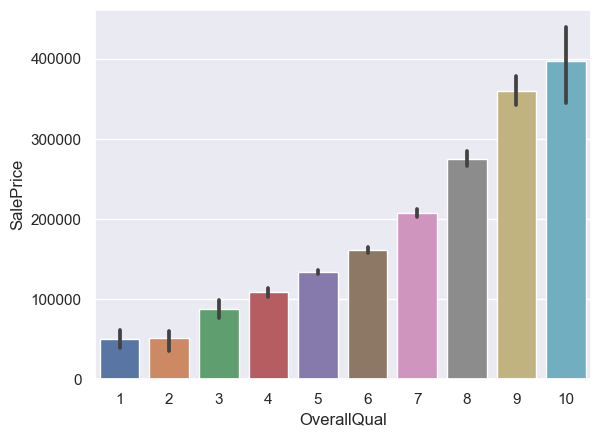

In [13]:
sns.barplot(df, x="OverallQual", y="SalePrice")

<a id='1.1.2'> </a>

### GrLivArea


In [14]:
px.histogram(df, x="GrLivArea", color="Train_test", color_discrete_sequence=cm)

We can notice the obvious outliers in the area above 3000. I deleted several rows in the train data and changed the values for the others in the test data


In [15]:
df.drop(df[(df["GrLivArea"] > 5000) & ~df["SalePrice"].isnull()].index, inplace=True)
df.loc[df["GrLivArea"] > 2800, "GrLivArea"] = 2800

In [16]:
px.histogram(df, x="GrLivArea", color="Train_test", color_discrete_sequence=cm)

<a> </a>

### GarageArea/GarageCars


In [17]:
px.imshow(df[["GarageArea", "GarageCars"]].corr(), color_continuous_scale=cm)

Garage Area and Garage Cars are highly correlated, so I think it's better to keep just one of these features


In [18]:
px.histogram(df, x="GarageCars", color="Train_test", color_discrete_sequence=cm)

In [19]:
px.histogram(df, x="GarageArea", color="Train_test", color_discrete_sequence=cm)

Garage Area looks more informative.

Let's change zeros to small values to help NN to deal with that. Plus, as I've done before, some rare big values will be changed


In [20]:
df.loc[df["GarageArea"] == 0, "GarageArea"] = 0.1
df.loc[df["GarageArea"] > 950, "GarageArea"] = 950

In [21]:
px.histogram(df, x="GarageArea", color="Train_test", color_discrete_sequence=cm)

In [22]:
df.drop(["GarageCars"], axis=1, inplace=True)

<a> </a>

### TotalBsmtSF


In [23]:
px.histogram(df, x="TotalBsmtSF", color="Train_test", color_discrete_sequence=cm)

In [24]:
df.loc[df["TotalBsmtSF"] == 0, "TotalBsmtSF"] = 0.1
df.loc[df["TotalBsmtSF"] > 2250, "TotalBsmtSF"] = 2250

In [25]:
px.histogram(df, x="TotalBsmtSF", color="Train_test", color_discrete_sequence=cm)

<a> </a>

### 1stFlrSF


In [26]:
px.histogram(df, x="1stFlrSF", color="Train_test", color_discrete_sequence=cm)

In [27]:
df.loc[df["1stFlrSF"] > 2500, "1stFlrSF"] = 2500

In [28]:
px.histogram(df, x="1stFlrSF", color="Train_test", color_discrete_sequence=cm)

<a> </a>

### FullBath


In [29]:
px.histogram(df, x="FullBath", color="Train_test", color_discrete_sequence=cm)

In [30]:
df.loc[df["FullBath"] == 4, "FullBath"] = 3

<a> </a>

### TotRmsAbvGrd


In [31]:
px.histogram(df, x="TotRmsAbvGrd", color="Train_test", color_discrete_sequence=cm)

In [32]:
df.loc[df["TotRmsAbvGrd"] > 12, "TotRmsAbvGrd"] = 12

<a> </a>

### YearBuilt/YearRemodAdd


I combined YearBuilt and YearRemodAdd in a column


In [33]:
df["YearBuilt/Remod"] = df["YearBuilt"].copy()
df.loc[df["YearBuilt"] > 1950, "YearBuilt/Remod"] = df.loc[
    df["YearBuilt"] > 1950, "YearRemodAdd"
]

In [34]:
px.histogram(df, x="YearBuilt/Remod", color="Train_test", color_discrete_sequence=cm)

In [35]:
df.loc[df["YearBuilt/Remod"] < 1895, "YearBuilt/Remod"] = 1895

<a id="2"></a>

# 2. Preprocessing


I will delete all columns with a lot of nan values


In [36]:
df = my_module.delete_nan_column(df, 0.25)

numeric_features = my_module.get_type_features(df, ["int64", "float64"])
categorical_features = my_module.get_type_features(df, ["object"])

In [37]:
numeric_features.append(numeric_features.pop(numeric_features.index("SalePrice")))

Imput median values in the numeric columns


In [38]:
for col in numeric_features[:-1]:
    imp = SimpleImputer(missing_values=np.nan, strategy="median")
    df[[col]] = imp.fit_transform(df[[col]])
df[numeric_features].isnull().sum().sum()

1459

In [39]:
predictive_features = my_module.get_corr_features(
    df[numeric_features].corr()["SalePrice"], 0.6
)
df_final = df[predictive_features].copy(deep=True)
df_final.head()

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice
0,7.00,856.00,856.00,1710.00,548.00,208500.00
1,6.00,1262.00,1262.00,1262.00,460.00,181500.00
2,7.00,920.00,920.00,1786.00,608.00,223500.00
3,7.00,756.00,961.00,1717.00,642.00,140000.00
4,8.00,1145.00,1145.00,2198.00,836.00,250000.00


Get the features with predictive power


In [40]:
scaler = preprocessing.StandardScaler()
df_final[df_final.columns[:-1]] = scaler.fit_transform(df_final.iloc[:, :-1])
df_final.head()

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice
0,0.65,-0.46,-0.80,0.46,0.37,208500.00
1,-0.06,0.52,0.28,-0.49,-0.05,181500.00
2,0.65,-0.30,-0.63,0.62,0.66,223500.00
3,0.65,-0.70,-0.52,0.47,0.83,140000.00
4,1.36,0.24,-0.03,1.48,1.76,250000.00


<a id="3"></a>

# 3. Model development


<a id='3.1'> </a>

## 3.1 Baseline


In [41]:
df_final.columns

Index(['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea',
       'SalePrice'],
      dtype='object')

In [42]:
features = [
    "OverallQual",
    "TotalBsmtSF",
    "GrLivArea",
    "GarageArea",
    "1stFlrSF",
    # 'YearBuilt/Remod',
    "SalePrice",
]

df_features = df_final[features]

In [43]:
my_module.test_nulls(df_features.iloc[:, :-1])

Engineered features do not contain nulls.


In [44]:
rng = 0
x = df_features[~df_features["SalePrice"].isna()][df_features.columns[:-1]]
y = df_features[~df_features["SalePrice"].isna()]["SalePrice"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=rng
)

In [45]:
my_module.check_distribution(x_train, x_test)

,OverallQual,TotalBsmtSF,GrLivArea,GarageArea,1stFlrSF
0,True,True,True,True,True


As we predict a continues value, we can use a mean value as a baseline


In [46]:
mean_price = np.full(len(x), np.mean(y))
my_module.print_evaluate_regression(mean_price, y)

MSE: 5692225017.019124
RMSLE: 0.1623656493871091
______


<a id='3.2'></a>

## 3.2 Simple model with a few features with predictive power


In [47]:
x_train.head()

,OverallQual,TotalBsmtSF,GrLivArea,GarageArea,1stFlrSF
92,-0.77,-0.41,-1.11,-0.18,-0.51
838,-0.77,0.13,-0.83,-0.57,-0.15
360,-0.06,-0.38,-1.22,-0.00,-0.65
665,1.36,0.87,0.93,0.16,0.80
40,-0.06,0.10,-0.36,-0.15,0.45


In [48]:
sample_weight = df.loc[x_train.index]["Sample_weights"]

KeyError: 'Sample_weights'

Final training loss: 1402902400.0
Final Validation loss: 873365632.0
10/10 [==============================] - 0s 1ms/step
MSE: 793856840.2135825
RMSLE: 0.02667277157065573
______


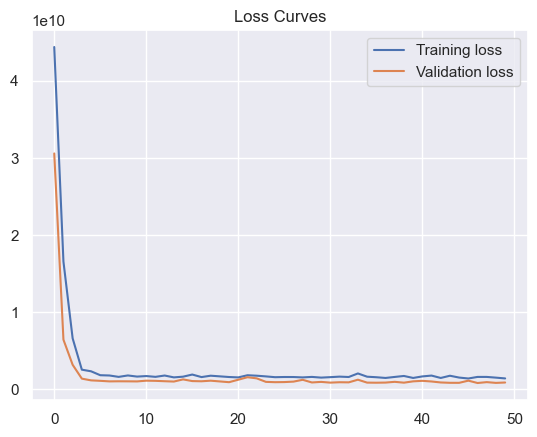

In [ ]:
learning_rate = 0.5
epochs = 50
batch_size = 50

model = None

# Define model
model = keras.Sequential()
model.add(
    keras.layers.Dense(
        units=x_train.shape[1],
        activation="relu",
        input_dim=x_train.shape[1],
        kernel_regularizer=tf.keras.regularizers.l2(l2=0.01),
    ),
)
model.add(
    keras.layers.Dense(
        units=x_train.shape[1],
        activation="relu",
        input_dim=x_train.shape[1],
        kernel_regularizer=tf.keras.regularizers.l2(l2=0.01),
    )
)

model.add(keras.layers.Dense(units=1, activation="linear"))
# Specify the optimizer using the TF API to specify the learning rate
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss="mse",
)

# Train the model
trainHistory = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0,
)
# Plot
my_module.showRegressionResults(trainHistory)


my_module.print_evaluate_regression(model.predict(x_test), y_test)

In [ ]:
import logging

logname = "model_results.log"

logging.basicConfig(
    filename=logname,
    filemode="a",
    format="%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

logger = logging.getLogger("my_logger")

logging.info("Logging set")
logging.info(model.to_json())
logging.info(features[:-1])
my_module.log_evaluate_regression(model.predict(x_test), y_test)
logging.shutdown()

10/10 [==============================] - 0s 1ms/step


In [ ]:
x_sub = df_final.loc[df_final["SalePrice"].isna()][features[:-1]]
pred = model.predict(x_sub, batch_size=batch_size).flatten()

sub = pd.DataFrame({"Id": test_ID, "SalePrice": pred})
my_module.test_nulls(sub)
sub.to_csv("submission.csv", index=False)

30/30 [==============================] - 0s 965us/step
Engineered features do not contain nulls.
